[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/activity_and_roles_detection.ipynb)


<!-- # **SIGNAL**ing LKML `activity usage` evolution  -->
# SIGNAL*ing* `developer activities and roles` in LKML
<!-- <h1 style="font-size:20em;"> <strong>SIGNAL</strong><i>ing</i> <code>developer activities and roles</code> in LKML<h1> -->

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

## 🪄 Install `needed` libraries

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy import inf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# the following cells are inspired by https://jbhender.github.io/Stats506/F18/GP/Group15.html
from sklearn.cluster import AgglomerativeClustering

In [13]:
import warnings
import pprint

In [14]:
try:
  from google.colab import data_table
  # disabling colabs data table formatter
  # as this formatter throws the following warning
  # Warning: Total number of columns (28) exceeds max_columns (20). Falling back to pandas display.
  # data_table.enable_dataframe_formatter()
  data_table.disable_dataframe_formatter()
except Exception:
  print("Launched notebook locally")

In [15]:
# Install required factor analysis package
try:
  from factor_analyzer import FactorAnalyzer
except:
   !pip install factor_analyzer
# Import required libraries
from factor_analyzer import FactorAnalyzer

     |████████████████████████████████| 41 kB 317 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=2044c2d69a9734ea02ab897a8d2dd1a4026b7e89fe766ea40d59f6697258ae3f
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer


In [16]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [17]:
import scipy.cluster.hierarchy as shc

# Check the Cophenetic Correlation Coefficient (https://en.wikipedia.org/wiki/Cophenetic_correlation) of the dendrogam
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import euclidean, pdist # computing the distance

## ✍ Set `needed` configuration

In [18]:
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(indent=4)

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:
# Format only numerical columns
# thx to https://stackoverflow.com/questions/51684585
# and https://www.kite.com/python/answers/how-to-display-float-values-in-a-pandas-dataframe-to-two-decimal-places-in-python
pd.options.display.float_format = "{:,.8f}".format

In [21]:
np.random.seed(0)

In [22]:
# data can come from 
IS_LOCAL_FILE = False

## ⚙ Define `helper` functions

In [23]:
from itertools import islice

# a few helper methods
def take(n, iterable):
  "Return first n items of the iterable as a list"
  return list(islice(iterable, n))

def take_from_dict(n, d):
  return take(n, d.items())

In [24]:
# style cells in pandas tables
def style_negative(v, props=''):
  return props if v < 0 else None

def highlight_eigenvalues(x, color):
  return np.where(x > 1.0, f"background-color: {color};", None)

In [25]:
def yellow_scores(x):
  return np.where(x >= 0.7, f"background-color: yellow;", None)

def green_scores(x):
  return np.where(((x >= 0.3) & (x < 0.7)), f"background-color: #e6ffe6;", None)

def pink_scores(x):
  return np.where(((x >= 0.1) & (x < 0.3)), f"background-color: #ffe6e6;", None)

In [26]:
# thx to https://bit.ly/3siFoaZ
def make_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = shc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('cluster size')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [27]:
# adapted from wss_calculation in https://jbhender.github.io/Stats506/F18/GP/Group15.html
def wss_calculation(K, data):
    WSS = []
    for i in range(K):
        cluster = AgglomerativeClustering(n_clusters= i+1, affinity='euclidean', linkage='average')  
        cluster.fit_predict(data)
        # cluster index
        label = cluster.labels_
        print(i+1, label)
        wss = []
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

In [28]:
def find_no_clusters(Z_input):
  last = Z_input[-10:, 2]
  last_rev = last[::-1]
  idxs = np.arange(1, len(last) + 1)

  plt.figure(figsize=(10,5))
  plt.title('Optimal number of cluster')
  plt.xlabel('Number of cluster')

  plt.plot(idxs, last_rev, marker = "o", label="distance")

  accele = np.diff(last, 2)  # 2nd derivative of the distances
  accele_rev = accele[::-1]
  plt.plot(idxs[:-2] + 1, accele_rev, marker = "x", label = "2nd derivative of distance growth")

  plt.legend()
  plt.show()
  k = accele_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
  print ("clusters:", k)

In [29]:
# euclidean dist function
dist = euclidean

def compute_RCI(df_r):
  # Role change intensity in time period (regardless of senders)
  RCI = 0.0
  for (i,x),(j,y) in zip(df_r[:-1].iterrows(),df_r[1:].iterrows()):
    R_cur = y['Role'].astype(np.int64)
    R_prev = x['Role'].astype(np.int64)
    RCI += (dist(role_centers[R_cur], role_centers[R_prev]))

  return round(np.log10(RCI), 2)

In [30]:
def ack(txt):
  if "Acknowledgement and Response" == txt:
    return "Ack/ Response"
  return txt

def abbreviate(txt):
  return ''.join(word[0] for word in txt.split()).upper()

def split_txt(txt):
  return '\n'.join(word for word in txt.split()).upper()

def realign_polar_xticks(ax):
    for x, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        if np.sin(x) > 0.1:
            label.set_horizontalalignment('left')
        if np.sin(x) < -0.1:
            label.set_horizontalalignment('right')

def make_spider(row, title, color):

    # number of variable
    categories = list(roles_df_T.columns)
    # categories = [ '\n'.join(wrap(l, 15)) for l in categories ]
    # categories = [abbreviate(str(l)) for l in categories]
    categories = [ack(str(l)) for l in categories]
    categories = [split_txt(str(l)) for l in categories]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # # print(noise)
    # angles = angles + noise

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row + 1, polar=True,)
    # ax.set_facecolor('#f2efe8')
    # ax.set_facecolor('#F6F6F6')

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(0, 1.)
    ax.set_yticks([])
    # ax.yaxis.grid(False)
    # ax.xaxis.grid(False)
    ax.yaxis.grid(linewidth=3)
    ax.yaxis.grid(linewidth=3)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=8)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    ax.set_rlabel_position(180)

    # thx to https://stackoverflow.com/questions/55424352
    # for label,i in zip(ax.get_xticklabels(),range(10,len(angles))):
    #     <code goes here>

    # # Removes spines
    # ax.spines["start"].set_color("none")
    # ax.spines["polar"].set_color("none")
    realign_polar_xticks(ax)

    PAD = 0.05
    ax.text(0.05, 0 + PAD, "5%", size=8, color=DARK_GRAY, fontname="Roboto")
    ax.text(0.05, 0.25 + PAD, "25%", size=8, color=DARK_GRAY, fontname="Roboto")
    ax.text(0.05, 0.5 + PAD, "50%", size=8, color=DARK_GRAY, fontname="Roboto")
    ax.text(0.05, 0.75 + PAD, "75%", size=8, color=DARK_GRAY, fontname="Roboto")
    ax.text(0.05, 0.9 + PAD, "100%", size=8, color=DARK_GRAY, fontname="Roboto")

    # Ind1
    values=roles_df_T.loc[row].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=.4)


    # Add a title (with title positioning using y, and loc in {right, center, left})
    plt.title(title, size=12, color=color, y=1.2, loc='center')

## 🧹 Data cleaning and preparation

In [31]:
# Load preprocessed data and remove unnecessary columns
# data_file = 'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/lkml_developer_from0820_0121.csv'
data_file = 'https://raw.githubusercontent.com/hsanchez/colabs/main/lstm/processed_dev_df_range20200101_20201231_V5.csv'
if IS_LOCAL_FILE:
  data_file = '../data/lkml_developer_from0820_0121.csv'

df = pd.read_csv(data_file, sep='\t')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,sender_name,sender_email,sender_id,is_maintainer,nr_aliases,is_bot,email_id,sent_time,received_time,message_exper,...,is_patch_churn,is_patch_set,is_bug_fix,is_new_feature,is_accepted_patch,is_accepted_commit,in_reply_to,project_id,commit_exper,time_lapse
0,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053535,2020-08-20 09:35:35+00:00,2020-08-20 05:35:35-0500,0,...,1,1,1,1,0,0,"20,200,820,091,517.00000000",-1,0,17.00000000
1,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053552,2020-08-20 09:35:52+00:00,2020-08-20 05:35:52-0500,1,...,1,1,1,1,0,0,"20,200,820,053,535.00000000",-1,0,3.00000000
2,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053555,2020-08-20 09:35:55+00:00,2020-08-20 05:35:55-0500,2,...,1,1,1,1,0,0,"20,200,820,053,552.00000000",-1,0,7.00000000
3,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053602,2020-08-20 09:36:02+00:00,2020-08-20 05:36:02-0500,3,...,1,1,1,1,0,0,"20,200,820,053,555.00000000",-1,0,4.00000000
4,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053606,2020-08-20 09:36:06+00:00,2020-08-20 05:36:06-0500,4,...,1,1,1,1,0,0,"20,200,820,053,602.00000000",-1,0,3.00000000


In [32]:
# Prior analysis on the LKML confirmed that patch emails
# tend to get a response within 3.5 hrs (on average).
# For sake of simplicity, we used 4 hrs instead of 3.5 hrs. 
# 4 * 60 * 60
four_h_lapse = 14400
df['reply_within_4hr'] = df['time_lapse'].apply(lambda x: 1 if (x <= four_h_lapse and x != -1) else 0)
df['reply_within_4hr'].head()

0    1
1    1
2    1
3    1
4    1
Name: reply_within_4hr, dtype: int64

In [33]:
# Based on the persuasion strategies in 
# Wang, X., Shi, W., Kim, R., Oh, Y., Yang, S., Zhang, J., & Yu, Z. (2019). 
# Persuasion for good: Towards a personalized persuasive dialogue system for social good.
# arXiv preprint [arXiv:1906.06725](https://arxiv.org/abs/1906.06725) 
persuasion_label = dict({0: 'task-related-inquiry', 
                    1: 'credibility-appeal', 
                    2: 'logical-appeal', 
                    3: 'personal-related-inquiry', 
                    4: 'source-related-inquiry', 
                    5: 'donation-information', 
                    6: 'foot-in-the-door', 
                    7: 'emotion-appeal', 
                    8: 'self-modeling', 
                    9: 'personal-story',
                   10: 'Unknown'})

# all persuasion strategies - the unknown one
persuasion_set = persuasion_label.keys() - {10}
persuasion_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [34]:
# exert influence through persuasion
df['exert_influence'] = df['persuasion'].apply(lambda x: 1 if (x in persuasion_set) else 0)
df['exert_influence']

0        0
1        1
2        1
3        1
4        1
        ..
39343    1
39344    0
39345    1
39346    1
39347    0
Name: exert_influence, Length: 39348, dtype: int64

In [35]:
df.drop(['persuasion'], axis = 1, inplace=True)

In [36]:
# Original shape of our developer data
df.shape

(39348, 28)

In [37]:
# Filter all rows for which the developer's
# word count on their emails is greater than or equal to 50
df.drop(df[df['word_cnt'] < 50].index, inplace = True)

In [38]:
# Updated shape of our developer data
df.shape

(27411, 28)

In [39]:
# Turn datetime values into Unix second time
# unix sec time; thx to https://stackoverflow.com/questions/54312802/
# or to https://stackoverflow.com/questions/40881876/
df['sent_time'] = pd.to_datetime(df['sent_time']).astype(np.int64) / 10**9
df['received_time'] = pd.to_datetime(df['received_time']).astype(np.int64) / 10**9
df[['sent_time', 'received_time']].head()

,sent_time,received_time
1,"1,597,916,152.00000000","1,597,919,752.00000000"
2,"1,597,916,155.00000000","1,597,919,755.00000000"
3,"1,597,916,162.00000000","1,597,919,762.00000000"
4,"1,597,916,166.00000000","1,597,919,766.00000000"
5,"1,597,916,169.00000000","1,597,919,769.00000000"


In [40]:
# removes the is_ prefix from bool columns
column_rename_dic = {
    'is_patch_churn': 'patch_churn', 
    'is_bug_fix': 'bug_fix', 
    'is_new_feature': 'new_feature', 
    'is_accepted_patch': 'accepted_patch', 
    'is_accepted_commit': 'accepted_commit',
    'is_patch_email': 'patch_email',
    'is_first_patch_thread': 'first_patch_thread'}

df.rename(columns=column_rename_dic, inplace=True)
df.head()

,sender_name,sender_email,sender_id,is_maintainer,nr_aliases,is_bot,email_id,sent_time,received_time,message_exper,...,bug_fix,new_feature,accepted_patch,accepted_commit,in_reply_to,project_id,commit_exper,time_lapse,reply_within_4hr,exert_influence
1,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053552,"1,597,916,152.00000000","1,597,919,752.00000000",1,...,1,1,0,0,"20,200,820,053,535.00000000",-1,0,3.00000000,1,1
2,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053555,"1,597,916,155.00000000","1,597,919,755.00000000",2,...,1,1,0,0,"20,200,820,053,552.00000000",-1,0,7.00000000,1,1
3,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053602,"1,597,916,162.00000000","1,597,919,762.00000000",3,...,1,1,0,0,"20,200,820,053,555.00000000",-1,0,4.00000000,1,1
4,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053606,"1,597,916,166.00000000","1,597,919,766.00000000",4,...,1,1,0,0,"20,200,820,053,602.00000000",-1,0,3.00000000,1,1
5,Greg Kroah-Hartman,gregkh@linuxfoundation.org,0,1,0,0,20200820053609,"1,597,916,169.00000000","1,597,919,769.00000000",5,...,1,1,0,0,"20,200,820,053,606.00000000",-1,0,31.00000000,1,1


In [41]:
# Define features of interest
developer_features = ['fkre_score', 'fkgl_score', 'message_exper', 'commit_exper']
email_features = ['word_cnt', 'sentence_cnt', 'exert_influence', 'patch_email', 'first_patch_thread', 'sent_time', 'received_time', 'reply_within_4hr']
patch_features = ['patch_churn', 'bug_fix', 'new_feature', 'accepted_patch', 'accepted_commit']
cols_of_interest = developer_features + email_features + patch_features

print("Features of interest:")
cols_of_interest

Features of interest:


['fkre_score',
 'fkgl_score',
 'message_exper',
 'commit_exper',
 'word_cnt',
 'sentence_cnt',
 'exert_influence',
 'patch_email',
 'first_patch_thread',
 'sent_time',
 'received_time',
 'reply_within_4hr',
 'patch_churn',
 'bug_fix',
 'new_feature',
 'accepted_patch',
 'accepted_commit']

In [42]:
# Creates a dataframe for the features of interest
interest_df = df[cols_of_interest].copy()

# Compute catch email verbosity (ratio of word count to sentence count)
interest_df['verbosity'] = interest_df['word_cnt'] / interest_df['sentence_cnt']
## Replace NaN cases with Zero and the drop word and sentence counts
interest_df.fillna(value={'verbosity': 0}, inplace=True)
interest_df.drop(['word_cnt', 'sentence_cnt'], axis = 1, inplace=True)
interest_df.head()

,fkre_score,fkgl_score,message_exper,commit_exper,exert_influence,patch_email,first_patch_thread,sent_time,received_time,reply_within_4hr,patch_churn,bug_fix,new_feature,accepted_patch,accepted_commit,verbosity
1,-378.89000000,185.35000000,1,0,1,1,0,"1,597,916,152.00000000","1,597,919,752.00000000",1,1,1,1,0,0,480.00000000
2,-225.79000000,126.73000000,2,0,1,1,0,"1,597,916,155.00000000","1,597,919,755.00000000",1,1,1,1,0,0,330.00000000
3,-65.22000000,67.32000000,3,0,1,1,0,"1,597,916,162.00000000","1,597,919,762.00000000",1,1,1,1,0,0,181.00000000
4,-75.26000000,70.21000000,4,0,1,1,0,"1,597,916,166.00000000","1,597,919,766.00000000",1,1,1,1,0,0,187.00000000
5,-162.49000000,107.97000000,5,0,1,1,0,"1,597,916,169.00000000","1,597,919,769.00000000",1,1,1,1,0,0,290.00000000


In [43]:
# Update our features of interest
cols_of_interest = list(interest_df.columns.to_numpy())

print("Updated features of interest")
cols_of_interest

Updated features of interest


['fkre_score',
 'fkgl_score',
 'message_exper',
 'commit_exper',
 'exert_influence',
 'patch_email',
 'first_patch_thread',
 'sent_time',
 'received_time',
 'reply_within_4hr',
 'patch_churn',
 'bug_fix',
 'new_feature',
 'accepted_patch',
 'accepted_commit',
 'verbosity']

In [44]:
# Get all the binary columns in the dataframe
# thx to https://stackoverflow.com/questions/32982034 
bool_cols = [col for col in interest_df if np.isin(interest_df[col].unique(), [0, 1]).all()]
interest_df[bool_cols].head()

,exert_influence,patch_email,first_patch_thread,reply_within_4hr,patch_churn,bug_fix,new_feature,accepted_patch,accepted_commit
1,1,1,0,1,1,1,1,0,0
2,1,1,0,1,1,1,1,0,0
3,1,1,0,1,1,1,1,0,0
4,1,1,0,1,1,1,1,0,0
5,1,1,0,1,1,1,1,0,0


In [45]:
# Get number of records in our data frame and
# the number of features
(no_rows, no_feats) = interest_df.shape
print("Record count:", no_rows, "Feature count:", no_feats)

Record count: 27411 Feature count: 16


In [46]:
standard_scaler = StandardScaler()

# Standardize values to have mean zero and unit variance.
# (We will use these standardized data in factor analysis.)
## We first add Gaussian noise to all the values in the dataframe
## then we standardize their values using min-max scaler.

no_features = no_feats # noisy features (binary variables won't have noise)
# https://stackoverflow.com/questions/46093073/
mu, sigma = 0, 0.1 
# creating a noise with the same dimension as the dataset (2,2) 
noise = np.random.normal(mu, sigma, [no_rows, no_features]) 

# https://stackoverflow.com/questions/12525722/normalize-data-in-pandas
noisy_interest_df = interest_df + noise
interest_df_norm = noisy_interest_df.copy()
interest_df_norm[noisy_interest_df.columns] = standard_scaler.fit_transform(noisy_interest_df[noisy_interest_df.columns])
interest_df_norm.head()

,fkre_score,fkgl_score,message_exper,commit_exper,exert_influence,patch_email,first_patch_thread,sent_time,received_time,reply_within_4hr,patch_churn,bug_fix,new_feature,accepted_patch,accepted_commit,verbosity
1,-0.03409214,0.03037403,-0.44787749,-0.36449515,1.86342678,-0.00675504,0.02759587,-1.94569234,-1.94614731,0.81905614,0.35490635,0.77512879,0.54897353,-0.11611031,0.03923263,0.02808456
2,0.08603078,-0.08941593,-0.44723886,-0.39263531,-2.52159029,0.51785932,-0.00094856,-1.94569118,-1.94614604,0.43952124,0.32333553,0.24642604,0.79689542,0.51995464,-0.09768211,-0.09129920
3,0.21184999,-0.21105750,-0.44659991,-0.38344817,1.23128159,0.69438066,-0.41811077,-1.94568842,-1.94614343,0.44651128,-0.23944573,0.93504883,0.14076450,-0.38029463,-0.76479939,-0.20985879
4,0.20391419,-0.20479695,-0.44595320,-0.38135194,-0.49581994,-0.07216850,-0.29842234,-1.94568683,-1.94614182,0.79705153,0.10488213,0.18988017,0.08846235,-0.34323509,-0.55645345,-0.20528258
5,0.13560166,-0.12775258,-0.44531930,-0.38066203,-0.88912630,0.32431767,-0.04605381,-1.94568566,-1.94614060,0.48419933,0.43787606,0.08614386,0.02474671,-0.44673624,-0.31875245,-0.12316144


We draw our data from the data we produced in milestone 2, which describes developers participating in the LKML, their patch emails, and their socio-technical activity. However, we restricted our analysis to those patch emails meeting certain criteria: They must indicate either *accepted* or *rejected* patch emails, have been sent by valid submitters (i.e, developers whose identities can be confirmed in `patchwork`), have at least one reply, have written at least 50 words (or at least one sentence) in their email bodies, have a *known* persuasion strategy, and have been sent within a user specified time window (e.g., all emails sent to the LKML in 2020). This resulted dataframe (interest_df_norm) that holds a picture of the wealth of socio-technical activity occurring in the LKML.

In [47]:
interest_df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27411 entries, 1 to 39346
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fkre_score          27411 non-null  float64
 1   fkgl_score          27411 non-null  float64
 2   message_exper       27411 non-null  float64
 3   commit_exper        27411 non-null  float64
 4   exert_influence     27411 non-null  float64
 5   patch_email         27411 non-null  float64
 6   first_patch_thread  27411 non-null  float64
 7   sent_time           27411 non-null  float64
 8   received_time       27411 non-null  float64
 9   reply_within_4hr    27411 non-null  float64
 10  patch_churn         27411 non-null  float64
 11  bug_fix             27411 non-null  float64
 12  new_feature         27411 non-null  float64
 13  accepted_patch      27411 non-null  float64
 14  accepted_commit     27411 non-null  float64
 15  verbosity           27411 non-null  float64
dtypes: f

# 🔍 Identifying typical developer activities 🤸 in the LKML data

## ➕ (Optional) Adequacy test to evaluate the factorability of the data.

Based on prior analysis, we know we can do factor analysis on our data. However, if you want to test this, this is how to check for "factorability".

The followng code evaluates the factorability of our data. In this context, factorability means we can find some factors in our data. For this, we can use two methods: **(1) the Bartlett's test, and (2) the Kaiser-Meyer-Olkin test.**     

### 🧪 Bartlett's test

The Bartlett's test of sphericity checks whether or not the observed variables (features of interest) intercorrelate at all. To do that, it uses the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [48]:
# Test the adequacy of our data to factor analysis
# using the Bartlett's test

chi_square_value, p_value=calculate_bartlett_sphericity(interest_df_norm)

"is p-value statistically significant?", p_value == 0, p_value, chi_square_value

('is p-value statistically significant?', True, 0.0, 1325295.7286642757)

We can observe that the *p-value is 0.0*. This means our test was statistically significant, and thus we can use factor analysis. Note that having statistically significant test means that the observed correlation matrix is not an identity matrix.

### 🧪 Kaiser-Meyer-Olkin test

The Kaiser-Meyer-Olkin (KMO) test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [49]:
kmo_all,kmo_model=calculate_kmo(interest_df_norm)
round(kmo_model, 2)

0.66

The overall KMO for our data is **0.66**, which is good. This value indicates that you can proceed with your planned factor analysis.

## 👀 Activity recognition using factor analysis

Factor Analysis is an exploratory data analysis method we used to search influential latent variables (factors) from the set of observed variables in the new dataset. In other words, we use it to check whether a number of variables (features of interest) are linearly related to a smaller number of unobservable factors. To search for these influencial factors, we use *factor extraction* (Principal Axis Factors) and *factor rotation* (Oblique) operations.

To perform factor analysis, we are going to use the factor_analyzer package. For *factor extraction*, we will start with 10 factors (just an arbitrary number; factor_analyzer can produce more factors) and no rotation.

In [50]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(10, rotation=None)
fa.fit(interest_df_norm)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.82334350e+00, 3.00193324e+00, 2.15210485e+00, 2.08211424e+00,
       1.33041490e+00, 1.00009956e+00, 8.31271197e-01, 6.48503727e-01,
       5.97815779e-01, 2.22035193e-01, 1.04517259e-01, 1.03591536e-01,
       1.02190347e-01, 6.45457557e-05, 9.76944435e-08, 2.90730801e-08])

In [52]:
factor_labels = ['Factor' + ' ' + str(i + 1) for i in range(len(interest_df_norm.columns))]

eigenval_df = pd.DataFrame(data=ev, index=factor_labels, columns=["Eigenvalue"])
eigenval_df.style.apply(highlight_eigenvalues, color='yellow')

,Eigenvalue
Factor 1,3.823343
Factor 2,3.001933
Factor 3,2.152105
Factor 4,2.082114
Factor 5,1.330415
Factor 6,1.000100
Factor 7,0.831271
Factor 8,0.648504
Factor 9,0.597816
Factor 10,0.222035


*5 factors* were identified. Let's see this with a scree plot, a visual representation of these factors' eigenvalues.

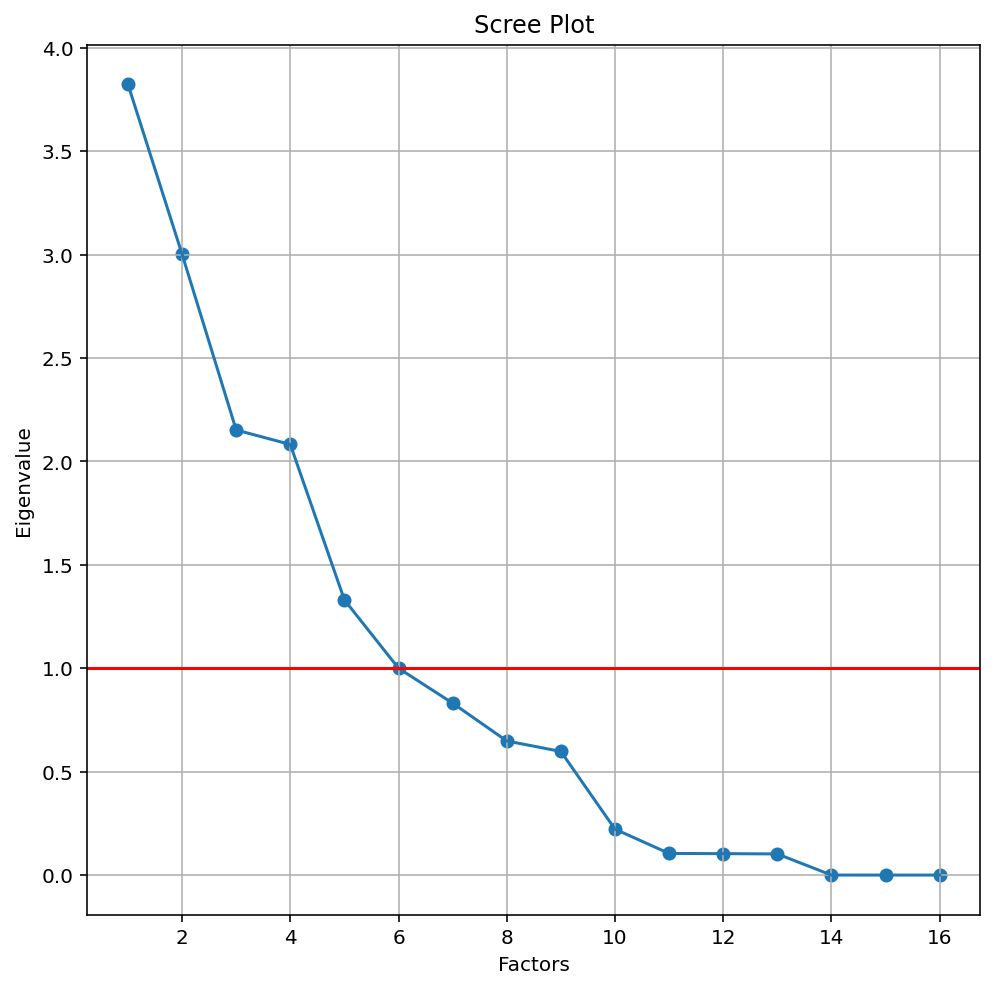

In [53]:
# Create scree plot using matplotlib
plt.figure(figsize =(8, 8))
plt.scatter(range(1,interest_df_norm.shape[1]+1),ev)
plt.plot(range(1,interest_df_norm.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.grid()
plt.show()

For *factor rotation*, we will use oblique rotation as this strategy will generate more accurate results when factors correlate. Since we know we have 5 factors, let's do factor extraction with 5 factor and oblique rotation. 

In [54]:
no_factors = 5
# Use oblique rotation to ensure correlation detection among features
fa = FactorAnalyzer(no_factors, rotation="oblimin")
fa.fit(interest_df_norm)
loadings_matrix = fa.loadings_
loadings_matrix.shape

(16, 5)

In [55]:
factor_labels = ['Factor' + ' ' + str(i + 1) for i in range(no_factors)]

# factors' loadings
loadings_df = pd.DataFrame(data = loadings_matrix, index = interest_df_norm.columns, columns = factor_labels)
loadings_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
fkre_score,-0.00014481,-0.99908103,-0.00085062,0.00022687,0.00073182
fkgl_score,-0.00017471,0.99916858,0.00004723,0.00019078,0.00003171
message_exper,-0.01265023,-0.00165396,0.00961205,-0.01188293,0.82867119
commit_exper,0.03607487,-0.02063958,0.03068089,0.11906871,0.38192724
exert_influence,0.01171874,-0.00392813,0.00311634,0.00250908,0.00237287
patch_email,0.94656184,0.00261183,0.00029291,-0.00319387,0.00351786
first_patch_thread,0.04264259,-0.00163286,0.02041115,0.48853446,-0.08304612
sent_time,0.00088538,0.00025288,0.99865195,-0.00031006,0.00084603
received_time,0.00087382,0.00025464,0.99862506,-0.00032086,0.00099729
reply_within_4hr,0.15534690,0.02458980,-0.10184457,-0.00656213,0.35180590


Compute correlation matrix plot for factor loadings

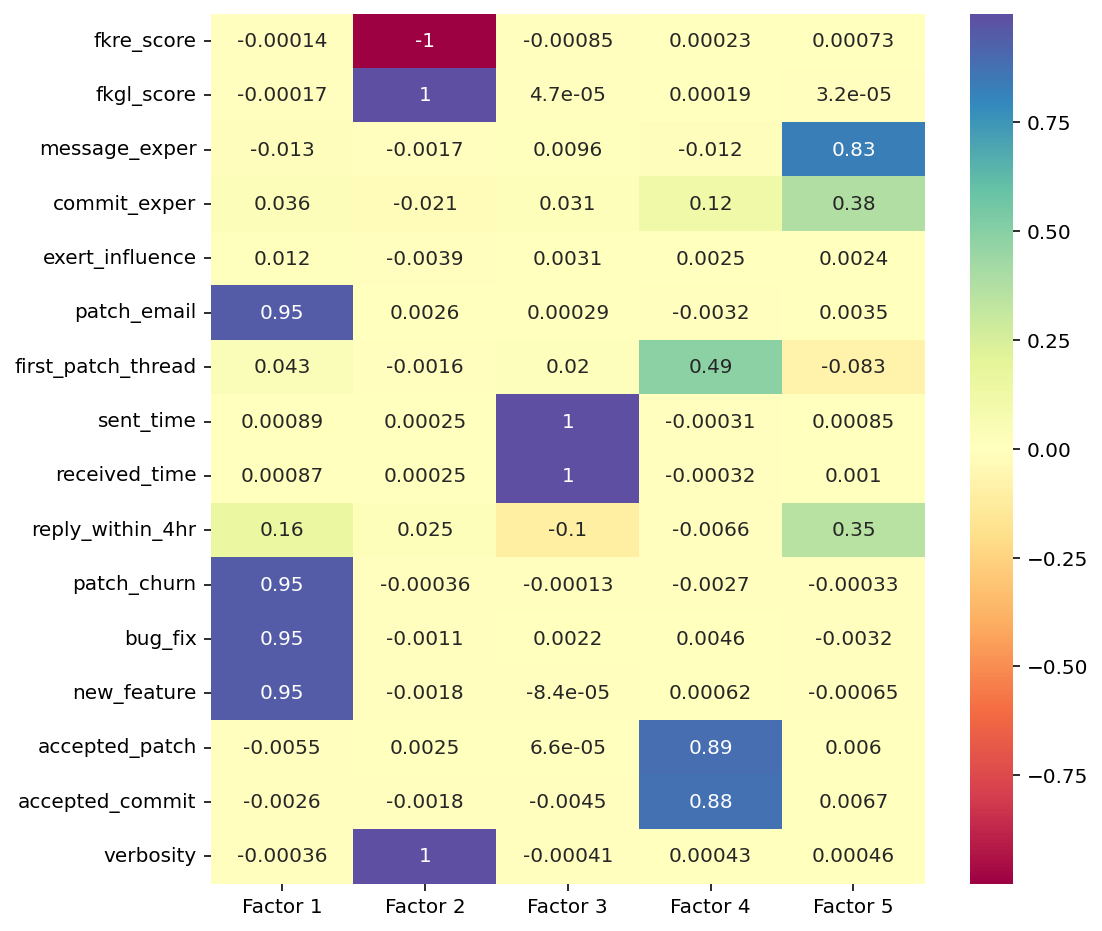

In [56]:
# get correlation matrix plot for loadings
plt.figure(figsize =(8, 8))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

We describe developer behavior in the above plot according to **5 types of activities** developers typically perform in the LKML:

<!-- 
| Activity | Factor | Description |
|---:|---|---|
| Code Contribution | Factor 1 | Contributing code changes to the Linux Kernel (LK). |
| Knowledge Sharing | Factor 2 | Commenting on specific topics, e.g., Voicing technical opinions, <br>providing suggestions, and asking or answering questions. |
| Patch Posting | Factor 3 | Responding to a bug report or a feature request through patch emails. |
| Progress Control | Factor 4 | Accounting for received patches that have been accepted or committed. |
| Acknowledgment and Response | Factor 5 | Patch acknowledgement, feedback, and landing by core maintainers. | -->



In [57]:
discovered_activities = {
    'Activity': ['Code Contribution', 
                 'Knowledge Sharing', 
                 'Patch Posting', 
                 'Progress Control', 
                 'Acknowledgment and Response'], 
    'Factor': ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5'], 
    'Description': ['Contributing code changes to the Linux Kernel (LK).', 
                    'Commenting on specific topics, e.g., Voicing technical opinions, providing suggestions, and asking or answering questions.', 
                    'Responding to a bug report or a feature request through patch emails.', 
                    'Accounting for received patches that have been accepted or committed.', 
                    'Patch acknowledgement, feedback, and landing by core maintainers.']}
dev_activities_df = pd.DataFrame.from_dict(discovered_activities)
dev_activities_df.style.set_properties(**{'text-align': 'left'})

,Activity,Factor,Description
0,Code Contribution,Factor 1,Contributing code changes to the Linux Kernel (LK).
1,Knowledge Sharing,Factor 2,"Commenting on specific topics, e.g., Voicing technical opinions, providing suggestions, and asking or answering questions."
2,Patch Posting,Factor 3,Responding to a bug report or a feature request through patch emails.
3,Progress Control,Factor 4,Accounting for received patches that have been accepted or committed.
4,Acknowledgment and Response,Factor 5,"Patch acknowledgement, feedback, and landing by core maintainers."


### Interpretation of factor scores

Interpretation of the correlation matrix plot:

**Factor 1**. 

It covers 5 features: *is_patch_email, is_patch_churn, is_bug_fix, is_new_feature, and is_replied_within_4hr*.

This factor describes code contribution (bug fixes, new features) to the LK. Such code changes tend to be answered within 4 hours. *We name this activity  **Code Contribution**.*



**Factor 2**.

It covers three features: *fkre_score, fkgl_score, and verbosity*.

This factor is associated with commenting actions[^1] associated with voicing/clarifying technical opinions, providing technical suggestions, and asking or answering questions. We thus name this activity **Knowledge Sharing**.

[^1]: Comments on a specific technical topic that is fairly difficult for the average adult to read.

**Factor 3**.

It covers two features: *sent_time_secs, and received_time_secs*.

This factor is only influenced by patch email sending and receiving actions. We thus name it **Patch Posting**. This type of activity is used to respond to a bug report or a feature request. This activity can go together with **Knowledge Sharing or Information Seeking**.

**Factor 4**.

It covers 4 features: *commit_exper, is_first_patch_thread, is_accepted_patch, and is_accepted_commit*.

This factor is influenced by actions related to the control of received, accepted and committed patches. At the same time, this activity involves developer with some commit experience.*Consequently, we name this activity as **Progress Control**.*

**Factor 5**.

It covers three features: *message_exper, commit_exper, and is_replied_within_4hr*.

This factor is influenced by actions associated with the acknowledgement, feedback, and landing of patches in the LK. This is done by core maintainers and these actions are not associated with patch posting activity.  *We name this activity **Acknowledgement and Response**.*

# 👀 Identifying developer roles in the LKML

In this section we are going to use the set of developer activitities (i.e., our latent factors) identified in the above sections to identify developer roles. Specifically, we perform clustering analysis on the factor scores representing these activities in order to identify the distinct roles developers assumed in the LKML.

Preparing data for clustering analysis

In [58]:
# Recover the sent_time feature based on the value
# of sent_time_secs
df_datetime = df.copy()
df_datetime['sent_time'] = pd.to_datetime(df['sent_time'] * 10**9)
df_datetime['sent_time'].head()

1   2020-08-20 09:35:52
2   2020-08-20 09:35:55
3   2020-08-20 09:36:02
4   2020-08-20 09:36:06
5   2020-08-20 09:36:09
Name: sent_time, dtype: datetime64[ns]

In [59]:
# Get the factor scores for our data, using the sender_id+sent_time as index.
# (Combining sender_id+sent_time gives us unique indices.)
fa_tranformed = fa.fit_transform(interest_df_norm)
df_factors = pd.DataFrame(data = fa_tranformed, 
                          index=pd.MultiIndex.from_frame(df_datetime[['sender_id', 'sent_time']]), 
                          columns = factor_labels)
df_factors

Factor 1    Factor 2    Factor 3    Factor 4  \
sender_id sent_time                                                             
0         2020-08-20 09:35:52  0.43641257  0.03096714 -1.94274141 -0.03178120   
          2020-08-20 09:35:55  0.48327745 -0.08905359 -1.94029429  0.20602998   
          2020-08-20 09:36:02  0.39737307 -0.21004953 -1.94646910 -0.57002163   
          2020-08-20 09:36:06  0.08587734 -0.20427279 -1.94273263 -0.44782348   
          2020-08-20 09:36:09  0.23177776 -0.12762567 -1.94879477 -0.37187544   
...                                   ...         ...         ...         ...   
866       2020-11-23 14:13:24  0.46913704 -0.34292268  1.27941572  0.00723487   
188       2020-11-23 14:14:25  0.13984506 -0.33919073  1.28403758 -0.00073295   
1043      2020-11-23 14:14:44  0.58968180 -0.12223670  1.27149283 -0.23285706   
675       2020-11-23 14:16:06 -2.79771537 -0.01715153  1.28071967 -0.16229443   
504       2020-11-23 14:16:07  0.26300015 -0.07794997  1.27413300 -0.28654085   

                                 Factor 5  
sender_id sent_time                        
0         2020-08-20 09:35:52 -0.49921948  
          2020-08-20 09:35:55 -0.54530702  
          2020-08-20 09:36:02 -0.47862222  
          2020-08-20 09:36:06 -0.47822064  
          2020-08-20 09:36:09 -0.44985071  
...                                   ...  
866       2020-11-23 14:13:24 -0.48190639  
188       2020-11-23 14:14:25 -0.52807636  
1043      2020-11-23 14:14:44 -0.44506979  
675       2020-11-23 14:16:06 -0.47405091  
504       2020-11-23 14:16:07 -0.36258343  

[27411 rows x 5 columns]

In [60]:
# Using the above index, determine the number of unique senders (aka developers)
cnt = df_factors.groupby(['sender_id']).count().shape[0]
print("Number of unique developers:", cnt) 

Number of unique developers: 1832


In [61]:
# Keep factor score between 0 and 1.
minmax_scaler = MinMaxScaler()
# Only used the df_factor_scaled for creating a composite index;
# for the clustering part use the df_factors
df_factors_scaled = pd.DataFrame(data = minmax_scaler.fit_transform(df_factors),
                                 index = pd.MultiIndex.from_frame(df_datetime[['sender_id', 'sent_time']]),
                                 columns = df_factors.columns)
df_factors_scaled#.head()


Factor 1   Factor 2   Factor 3   Factor 4  \
sender_id sent_time                                                         
0         2020-08-20 09:35:52 0.88378532 0.00919386 0.00483811 0.18766965   
          2020-08-20 09:35:55 0.89380675 0.00642655 0.00559190 0.22004646   
          2020-08-20 09:36:02 0.87543725 0.00363677 0.00368987 0.11439089   
          2020-08-20 09:36:06 0.80882807 0.00376996 0.00484081 0.13102756   
          2020-08-20 09:36:09 0.84002692 0.00553720 0.00297349 0.14136751   
...                                  ...        ...        ...        ...   
866       2020-11-23 14:13:24 0.89078301 0.00057312 0.99736187 0.19298150   
188       2020-11-23 14:14:25 0.82036834 0.00065917 0.99878554 0.19189672   
1043      2020-11-23 14:14:44 0.91655989 0.00566146 0.99492137 0.16029417   
675       2020-11-23 14:16:06 0.19221051 0.00808439 0.99776353 0.16990092   
504       2020-11-23 14:16:07 0.84670341 0.00668257 0.99573463 0.15298539   

                                Factor 5  
sender_id sent_time                       
0         2020-08-20 09:35:52 0.26486259  
          2020-08-20 09:35:55 0.25508479  
          2020-08-20 09:36:02 0.26923245  
          2020-08-20 09:36:06 0.26931765  
          2020-08-20 09:36:09 0.27533653  
...                                  ...  
866       2020-11-23 14:13:24 0.26853569  
188       2020-11-23 14:14:25 0.25874040  
1043      2020-11-23 14:14:44 0.27635083  
675       2020-11-23 14:16:06 0.27020228  
504       2020-11-23 14:16:07 0.29385090  

[27411 rows x 5 columns]

In [62]:
# Maps factors to activity names
activity_name = {'Factor 1': 'Code Contribution',
                 'Factor 2': 'Knowledge Sharing',
                 'Factor 3': 'Patch Posting', 
                 'Factor 4': 'Progress Control', 
                 'Factor 5': 'Acknowledgement and Response'}

print("Factor to Activity Map")
activity_name

Factor to Activity Map


{'Factor 1': 'Code Contribution',
 'Factor 2': 'Knowledge Sharing',
 'Factor 3': 'Patch Posting',
 'Factor 4': 'Progress Control',
 'Factor 5': 'Acknowledgement and Response'}

In [63]:
# Renames factors with their activity name
df_factors_scaled.rename(columns=lambda x: activity_name[x], inplace=True)
df_factors_scaled.head()

Code Contribution  Knowledge Sharing  \
sender_id sent_time                                                   
0         2020-08-20 09:35:52         0.88378532         0.00919386   
          2020-08-20 09:35:55         0.89380675         0.00642655   
          2020-08-20 09:36:02         0.87543725         0.00363677   
          2020-08-20 09:36:06         0.80882807         0.00376996   
          2020-08-20 09:36:09         0.84002692         0.00553720   

                               Patch Posting  Progress Control  \
sender_id sent_time                                              
0         2020-08-20 09:35:52     0.00483811        0.18766965   
          2020-08-20 09:35:55     0.00559190        0.22004646   
          2020-08-20 09:36:02     0.00368987        0.11439089   
          2020-08-20 09:36:06     0.00484081        0.13102756   
          2020-08-20 09:36:09     0.00297349        0.14136751   

                               Acknowledgement and Response  
sender_id sent_time                                          
0         2020-08-20 09:35:52                    0.26486259  
          2020-08-20 09:35:55                    0.25508479  
          2020-08-20 09:36:02                    0.26923245  
          2020-08-20 09:36:06                    0.26931765  
          2020-08-20 09:36:09                    0.27533653

In the context of modeling developer behavior, one may wonder whether these activities correlate with each other. To answer this question, we compute the correlation coefficients among these activities. 

In [64]:
coeff_df = df_factors_scaled.corr()
coeff_format = coeff_df.style.applymap(style_negative, props='color:red;').applymap(
    lambda v: 'opacity: 20%;' if (v == 1.0) and (v > -0.3) else None).set_caption(
        "Correlation coefficients among identified activities.")
coeff_format.set_table_styles([dict(selector="caption", props=[("caption-side", "bottom"), ("font-size", "1.15em"), ("color", "gray")])])

,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response
Code Contribution,1.000000,-0.024753,-0.033530,0.043758,0.196953
Knowledge Sharing,-0.024753,1.000000,-0.004327,-0.016353,-0.105671
Patch Posting,-0.033530,-0.004327,1.000000,0.023346,0.210813
Progress Control,0.043758,-0.016353,0.023346,1.000000,-0.104085
Acknowledgement and Response,0.196953,-0.105671,0.210813,-0.104085,1.000000


The above information demonstrates some correlations between the extracted activity dimensions. *This support our hypothesis that the factors influencing the actions developers take when participating in the LKML are not independent.* Consequently, we can use this insight to identify roles in our LKML data.

### Finding developer roles

We'll find developer roles in the LKML using *agglomerative hierarchical clustering* on the scaled factor scores.

In [65]:

# Partitions scaled factor scores into a set of clusters, using the ward method.
Z = shc.linkage(df_factors_scaled, method ='ward')
Z

array([[2.70520000e+04, 2.72060000e+04, 7.68248195e-04, 2.00000000e+00],
       [5.16000000e+02, 6.02000000e+02, 1.64482198e-03, 2.00000000e+00],
       [2.45700000e+04, 2.46760000e+04, 1.64643344e-03, 2.00000000e+00],
       ...,
       [5.48110000e+04, 5.48170000e+04, 3.65115764e+01, 1.56830000e+04],
       [5.48150000e+04, 5.48180000e+04, 4.97672908e+01, 1.83040000e+04],
       [5.48160000e+04, 5.48190000e+04, 6.00897900e+01, 2.74110000e+04]])

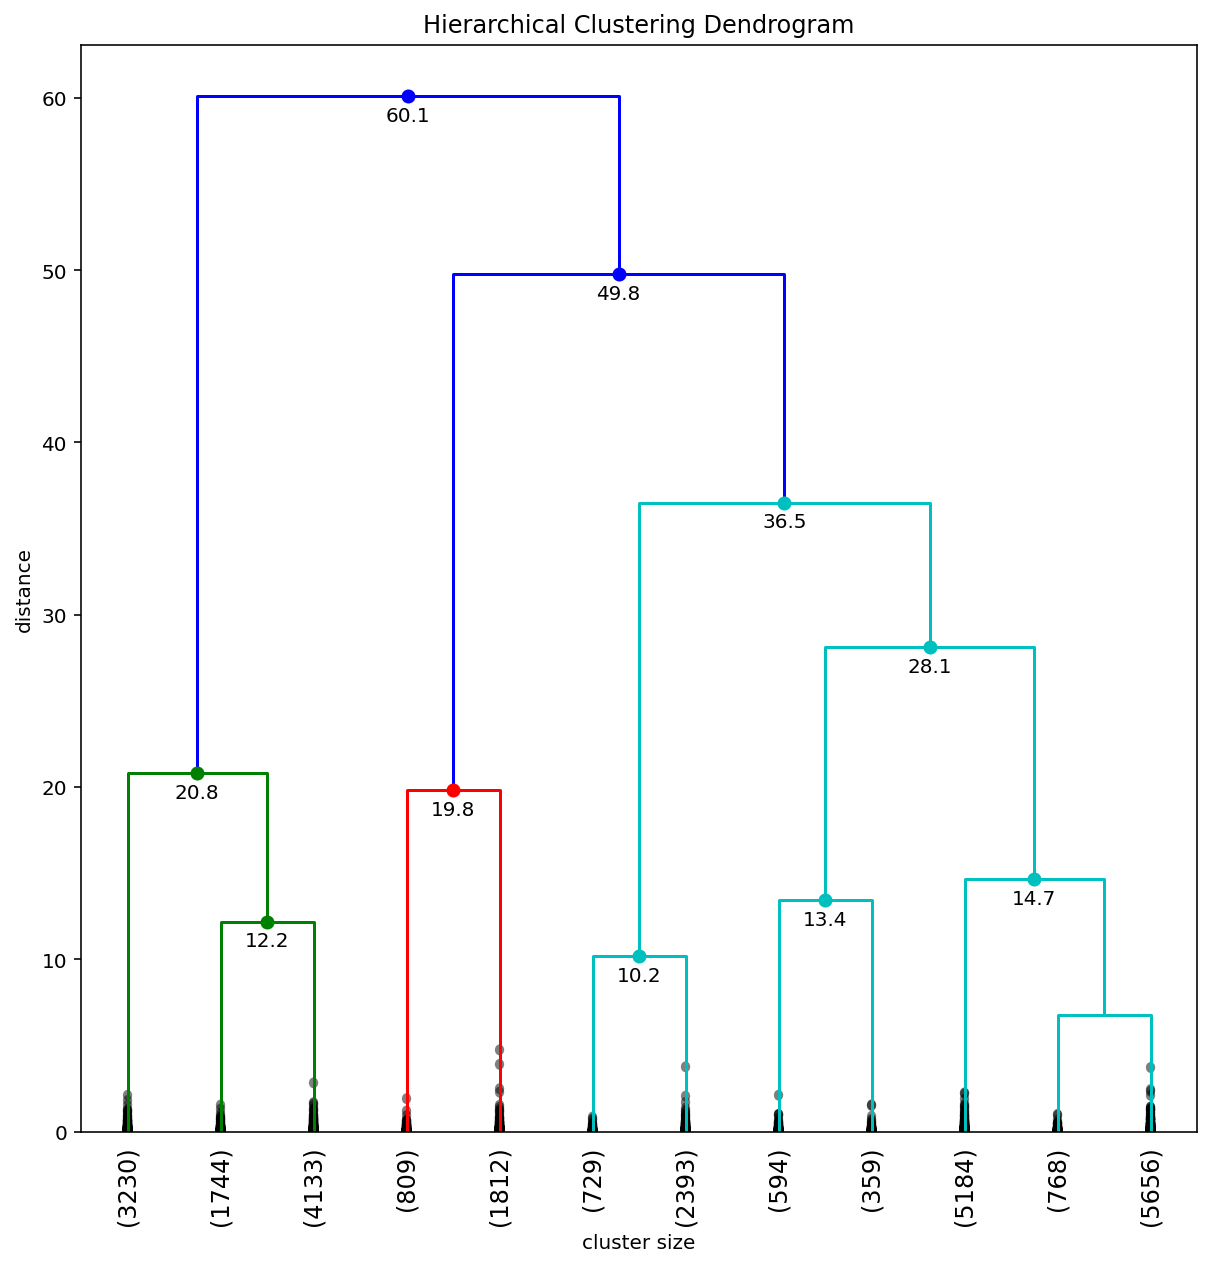

In [66]:
plt.figure(figsize =(10, 10))
# Hierarchical Clustering Dendrogram (truncated)
dendrogam = make_dendrogram(
    # the clusters
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90., 
    leaf_font_size=12., 
    show_contracted=True,
    annotate_above=10,)

In [67]:
c, coph_dists = cophenet(Z, pdist(df_factors_scaled))
round(c, 2)

0.73

The closer the value is to 1, the better the clustering preserves the original distances

Without a cuttoff line, the above dendrogram seems to indicate that we have 3 clusters in our data. Selecting a cuttoff line is tricky.
Let's use the elbow method to predict optimal number of clusters and see if this optimal value matches the above clusters.

According to wikipedia, the goal is to minimize the total intra-cluster variation (WSS). Therefore, we can implement the Elbow Method as a reference for determining the optimal number of clusters:

In [68]:
intra_cluster_variation = wss_calculation(10, df_factors_scaled.values)

1 [0 0 0 ... 0 0 0]
2 [0 0 0 ... 0 0 0]
3 [0 0 0 ... 0 2 0]
4 [1 1 1 ... 1 0 1]
5 [1 1 1 ... 1 0 1]
6 [1 1 1 ... 1 2 1]
7 [0 0 0 ... 0 2 0]
8 [1 1 1 ... 2 0 2]
9 [1 1 1 ... 0 8 0]
10 [0 0 0 ... 3 8 3]


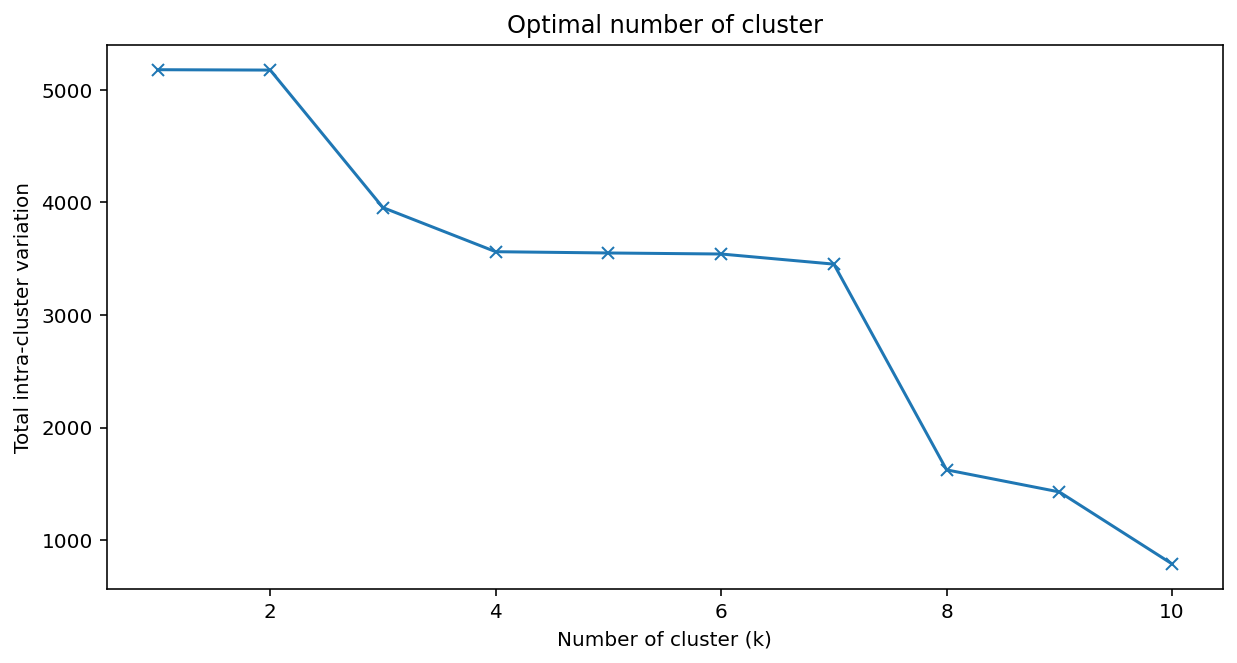

In [69]:
cluster_range = range(1, 11)

plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster (k)')
plt.ylabel('Total intra-cluster variation')
plt.plot(cluster_range, intra_cluster_variation, marker = "x")

The gain in explained variance reduces significantly from 3 to 5 to 6 (‘elbow’ is at k = 3). So, optimal number of clusters seems to be 3.
Alternatively, we can just focus on finding where the acceleration of distance growth is the biggest:



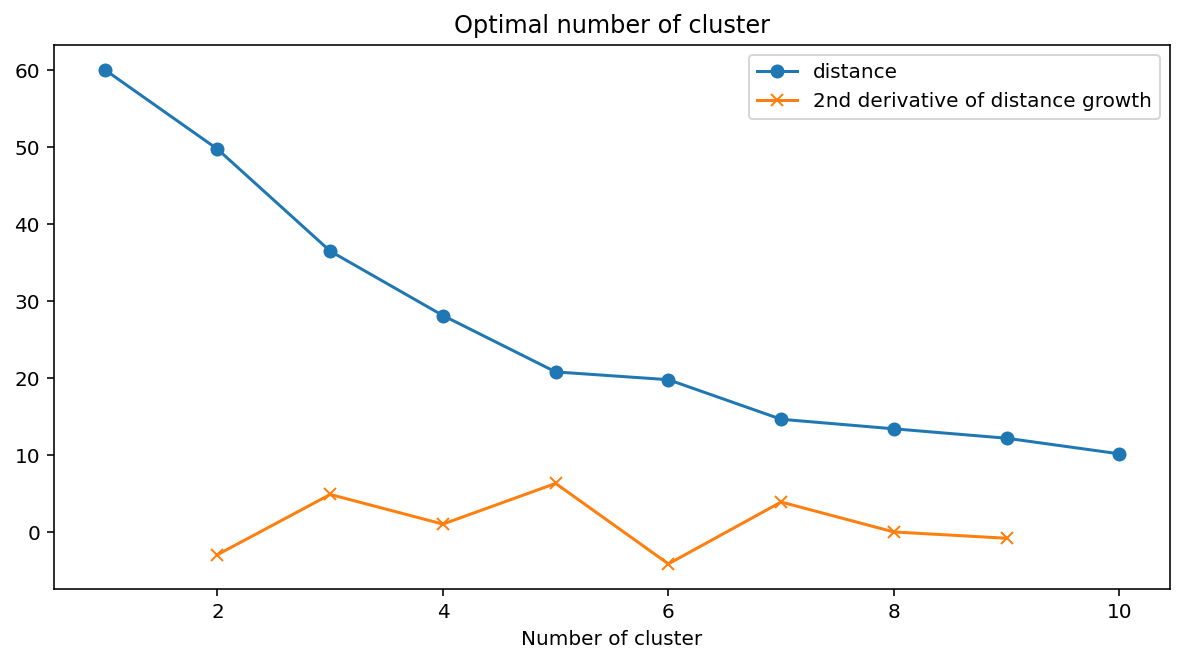

clusters: 5


In [70]:
# find optimal no of clusters using the acceleration of distance growth
find_no_clusters(Z)

According to the results of Elbow Method and the distance acceleration, we can select **5 clusters** for our dataset, and *therefore we can select the cut-off distance to be 25 as shown in the following figure.*

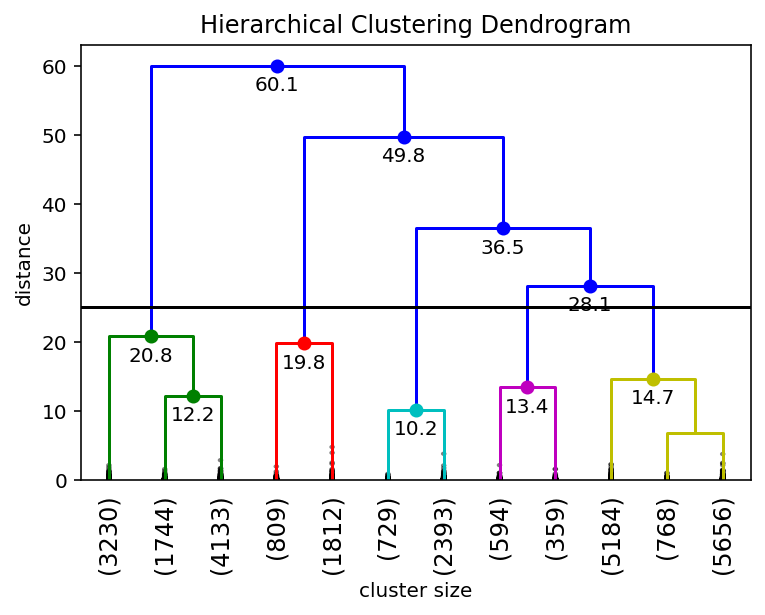

In [71]:
dendrogam_scaled_fancy = make_dendrogram(
    # the clusters
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    p=12,
    leaf_font_size=12., 
    show_contracted=True,
    annotate_above=10,
    max_d=25,  # a horizontal cut-off line
    )

In [72]:
# based on above dendrogam
no_clusters = 5

clusters = shc.fcluster(Z, no_clusters, criterion='maxclust')
pp.pprint({c for c in clusters})
# clusters

{1, 2, 3, 4, 5}


In [73]:
role_one = df_factors_scaled[clusters == 1].mean(0)
role_one

Code Contribution              0.85891729
Knowledge Sharing              0.00840694
Patch Posting                  0.24868113
Progress Control               0.16862950
Acknowledgement and Response   0.33310956
dtype: float64

In [74]:
role_two = df_factors_scaled[clusters == 2].mean(0)
# Outsider Information Seeker: not involved in contributions or patch coordination, seeks for information
role_two

Code Contribution              0.15124366
Knowledge Sharing              0.01032122
Patch Posting                  0.63325859
Progress Control               0.17501169
Acknowledgement and Response   0.26165578
dtype: float64

In [75]:
role_three = df_factors_scaled[clusters == 3].mean(0)
# ask a lot questions, they pester, and they offer a lot of patches.
role_three

Code Contribution              0.85951181
Knowledge Sharing              0.00398542
Patch Posting                  0.79141406
Progress Control               0.16367476
Acknowledgement and Response   0.82175443
dtype: float64

In [76]:
role_four = df_factors_scaled[clusters == 4].mean(0)
# Core maintainer; really involved in the management and direction (via patches) of the project
role_four

Code Contribution              0.85896857
Knowledge Sharing              0.00626082
Patch Posting                  0.63457763
Progress Control               0.81420936
Acknowledgement and Response   0.28538989
dtype: float64

In [77]:
role_five = df_factors_scaled[clusters == 5].mean(0)
role_five

Code Contribution              0.85689664
Knowledge Sharing              0.00951225
Patch Posting                  0.82149965
Progress Control               0.17069845
Acknowledgement and Response   0.31068282
dtype: float64

Putting it all together

In [78]:
data_frames = [role_one, role_two, role_three, role_four, role_five]
roles_df = pd.concat(data_frames, axis=1, ignore_index=True)
roles_df

,0,1,2,3,4
Code Contribution,0.85891729,0.15124366,0.85951181,0.85896857,0.85689664
Knowledge Sharing,0.00840694,0.01032122,0.00398542,0.00626082,0.00951225
Patch Posting,0.24868113,0.63325859,0.79141406,0.63457763,0.82149965
Progress Control,0.16862950,0.17501169,0.16367476,0.81420936,0.17069845
Acknowledgement and Response,0.33310956,0.26165578,0.82175443,0.28538989,0.31068282


In [79]:
styler = roles_df.style.apply(yellow_scores)
styler = styler.apply(green_scores)
styler = styler.apply(pink_scores)
styler = styler.applymap(style_negative, props='color:red;').applymap(
    lambda v: 'opacity: 20%;' if (v < 0.02) and (v > -0.3) else None)
styler = styler.set_caption("Centers of activity clusters.")
styler.set_table_styles([dict(selector="caption", props=[("caption-side", "bottom"), ("font-size", "1.15em"), ("color", "gray")])])
styler

,0,1,2,3,4
Code Contribution,0.858917,0.151244,0.859512,0.858969,0.856897
Knowledge Sharing,0.008407,0.010321,0.003985,0.006261,0.009512
Patch Posting,0.248681,0.633259,0.791414,0.634578,0.821500
Progress Control,0.168629,0.175012,0.163675,0.814209,0.170698
Acknowledgement and Response,0.333110,0.261656,0.821754,0.285390,0.310683


### Radar plot showing the activity space characteristics of roles in the LKML

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


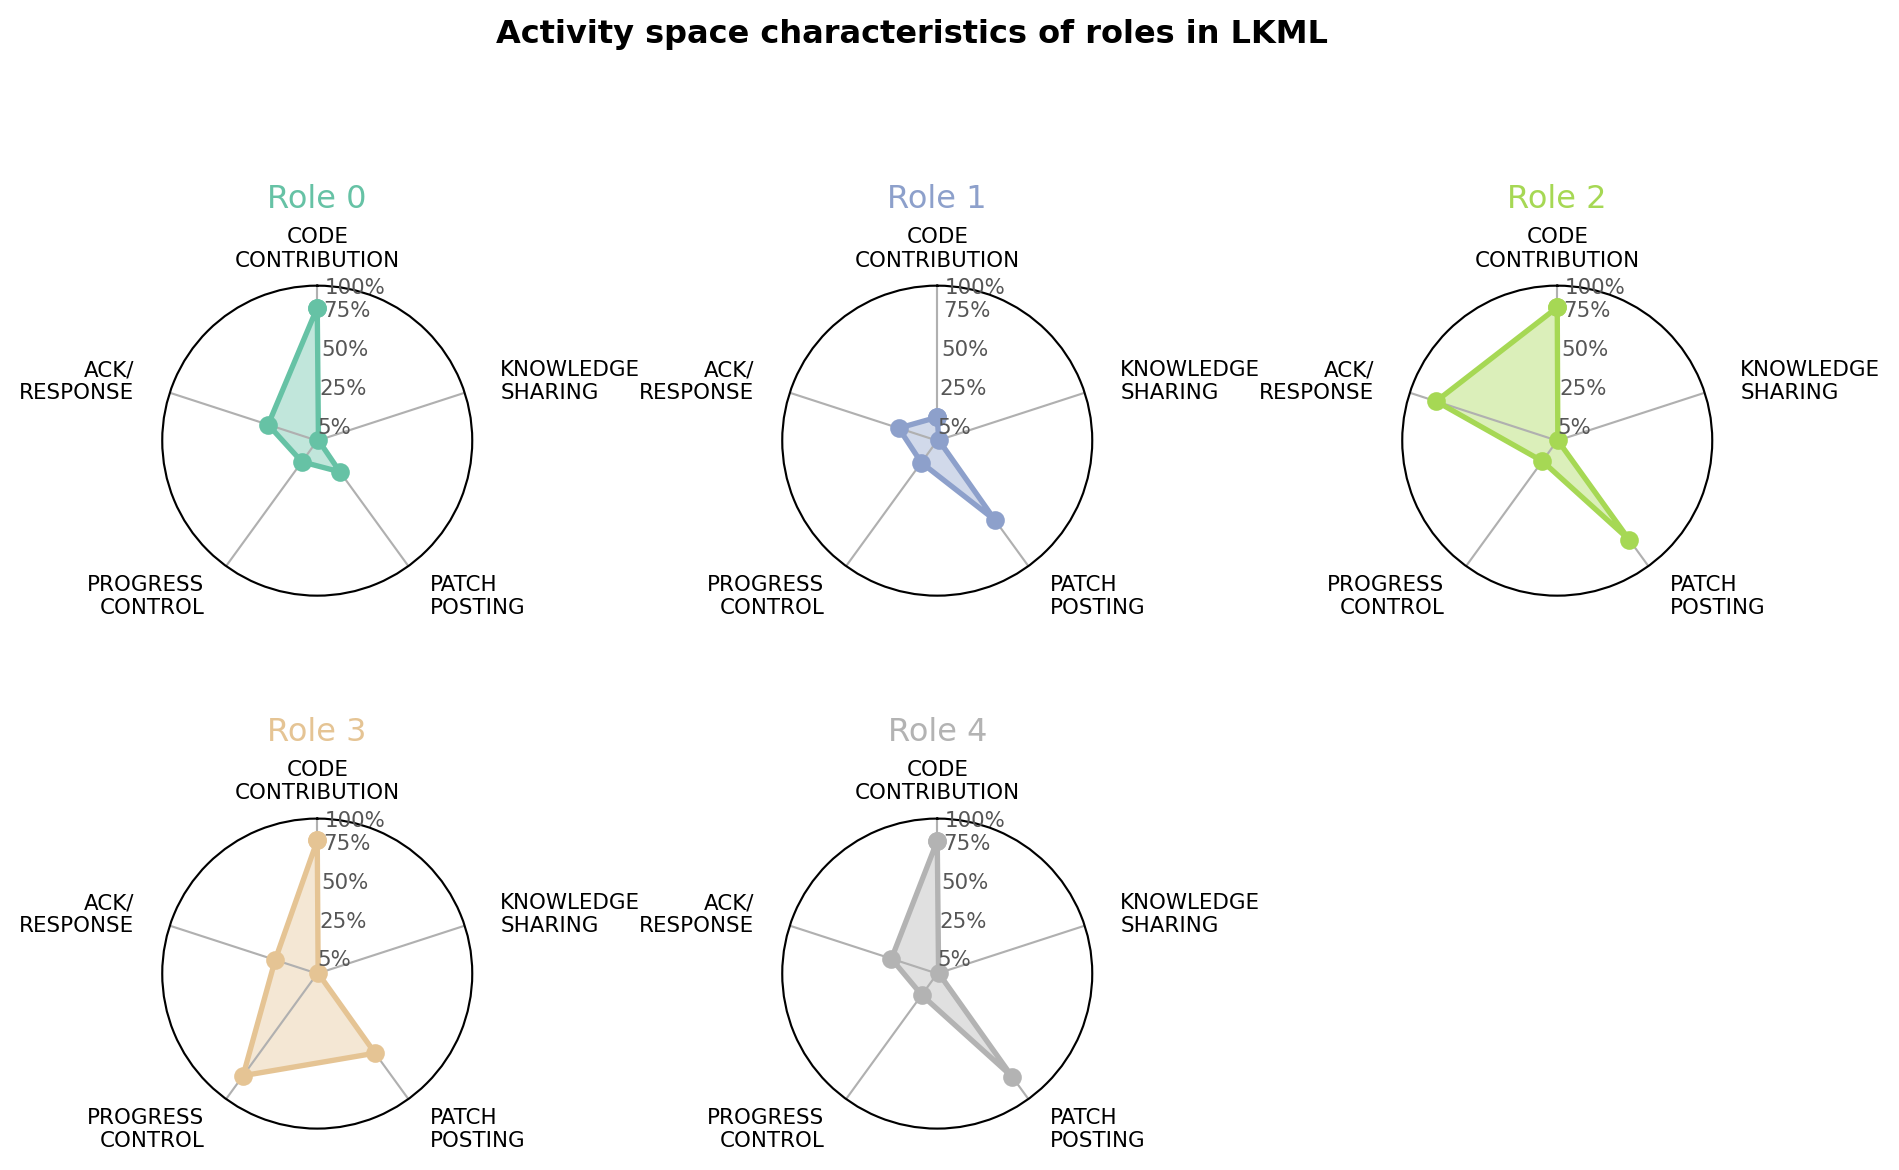

In [80]:
# plt.style.use('ggplot')

roles_df_T = roles_df.T

roles = list(roles_df_T.index)

DARK_GRAY = "#565656"

# initialize the figure
fig = plt.figure(figsize=(1000/96, 1000/96), dpi=96)
fig.suptitle('Activity space characteristics of roles in LKML', weight="bold")


# plt.tight_layout(pad=0.9)
# fig.subplots_adjust(wspace=0.5)
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# plt.subplots_adjust(wspace=.6)
fig.subplots_adjust(wspace=1)
 
# Create a color palette:
color_palette = plt.cm.get_cmap("Set2", len(roles))
 
# Loop to plot
for idx, row in enumerate(roles):
    make_spider(row=idx, title=f'\nRole {row}', color=color_palette(row))


Interpretation of Activity space of characteristics for roles

- **Role 0.**  Role 0 describes a type of developer that typically works in isolation; one that occasionally contributes to the kernel and when they do they contribute major changes. We name this role **Occasional developer**.
- **Role 1.** Role 1 describes a type of developer that rarely contributes to the Linux Kernel contributor. This type of developer barely participates in the LKML but when they do they submit a flurry of patch emails that tend to be ignored or rejected by maintainers. This type of developer avoids engaging in sharing knowledge activities and seems unaware of the Kernel's patch process. We name this role **Opportunistic programmer**, or **Rare contributor**.
- **Role 2.** Role 2 describes a type of developer that consistently focuses on making small code contributions to the Kernel's code or fixes bugs. We name this role **Engaged core developer**.
- **Role 3.** Role 3 describes a type of developer who is an active contributor and frequently engages in the progress control activity concerning posted patches. We name this role **Core maintainer**.
- **Role 4.** Role 4 describes a type of developer that works in isolation, and and tends to provoke or incite an action or change in project direction. We name this role **Instigator**.


# 🌡 Measuring Role dynamics 🤹 in the LKML

Preparing the factors data frame for role dynamics analysis. This task is based on the RCI score computation described in [Cheng et al. 2019](https://arxiv.org/abs/1903.05277).

In [81]:
role_map = {}
for role_id, role_name in zip(roles, ['Occasional developer', 'Opportunistic programmer', 'Engaged code developer', 'Core maintainer', 'Instigator']):
  role_map[role_id + 1] = role_name

role_map

{1: 'Occasional developer',
 2: 'Opportunistic programmer',
 3: 'Engaged code developer',
 4: 'Core maintainer',
 5: 'Instigator'}

In [82]:
# Adding role column
df_factors_scaled_roles = df_factors_scaled.copy()
df_factors_scaled_roles['Role'] = clusters
df_factors_scaled_roles.head()

Code Contribution  Knowledge Sharing  \
sender_id sent_time                                                   
0         2020-08-20 09:35:52         0.88378532         0.00919386   
          2020-08-20 09:35:55         0.89380675         0.00642655   
          2020-08-20 09:36:02         0.87543725         0.00363677   
          2020-08-20 09:36:06         0.80882807         0.00376996   
          2020-08-20 09:36:09         0.84002692         0.00553720   

                               Patch Posting  Progress Control  \
sender_id sent_time                                              
0         2020-08-20 09:35:52     0.00483811        0.18766965   
          2020-08-20 09:35:55     0.00559190        0.22004646   
          2020-08-20 09:36:02     0.00368987        0.11439089   
          2020-08-20 09:36:06     0.00484081        0.13102756   
          2020-08-20 09:36:09     0.00297349        0.14136751   

                               Acknowledgement and Response  Role  
sender_id sent_time                                                
0         2020-08-20 09:35:52                    0.26486259     1  
          2020-08-20 09:35:55                    0.25508479     1  
          2020-08-20 09:36:02                    0.26923245     1  
          2020-08-20 09:36:06                    0.26931765     1  
          2020-08-20 09:36:09                    0.27533653     1

In [83]:
# index role centers
role_centers = {}
for role_id, role_center in zip(roles, [role_one, role_two, role_three, role_four, role_five]):
  role_centers[role_id + 1] = role_center

len(role_centers)

5

In [84]:
roles_index = df_factors_scaled_roles.reset_index() #.drop('sender_id', axis=1).sort_values(by = 'sent_time')
# roles_index = roles_index.drop("sender_id", axis=1)
roles_index = roles_index.sort_values(by = 'sent_time')
roles_index

,sender_id,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Role
0,0,2020-08-20 09:35:52,0.88378532,0.00919386,0.00483811,0.18766965,0.26486259,1
1,0,2020-08-20 09:35:55,0.89380675,0.00642655,0.00559190,0.22004646,0.25508479,1
2,0,2020-08-20 09:36:02,0.87543725,0.00363677,0.00368987,0.11439089,0.26923245,1
3,0,2020-08-20 09:36:06,0.80882807,0.00376996,0.00484081,0.13102756,0.26931765,1
4,0,2020-08-20 09:36:09,0.84002692,0.00553720,0.00297349,0.14136751,0.27533653,1
...,...,...,...,...,...,...,...,...
27406,866,2020-11-23 14:13:24,0.89078301,0.00057312,0.99736187,0.19298150,0.26853569,5
27407,188,2020-11-23 14:14:25,0.82036834,0.00065917,0.99878554,0.19189672,0.25874040,5
27408,1043,2020-11-23 14:14:44,0.91655989,0.00566146,0.99492137,0.16029417,0.27635083,5
27409,675,2020-11-23 14:16:06,0.19221051,0.00808439,0.99776353,0.16990092,0.27020228,2


In [85]:
roles_index = roles_index.set_index(['sent_time'])
roles_index

,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Role
sent_time,,,,,,,
2020-08-20 09:35:52,0,0.88378532,0.00919386,0.00483811,0.18766965,0.26486259,1
2020-08-20 09:35:55,0,0.89380675,0.00642655,0.00559190,0.22004646,0.25508479,1
2020-08-20 09:36:02,0,0.87543725,0.00363677,0.00368987,0.11439089,0.26923245,1
2020-08-20 09:36:06,0,0.80882807,0.00376996,0.00484081,0.13102756,0.26931765,1
2020-08-20 09:36:09,0,0.84002692,0.00553720,0.00297349,0.14136751,0.27533653,1
...,...,...,...,...,...,...,...
2020-11-23 14:13:24,866,0.89078301,0.00057312,0.99736187,0.19298150,0.26853569,5
2020-11-23 14:14:25,188,0.82036834,0.00065917,0.99878554,0.19189672,0.25874040,5
2020-11-23 14:14:44,1043,0.91655989,0.00566146,0.99492137,0.16029417,0.27635083,5


In [86]:
# thx to https://stackoverflow.com/questions/42255458/how-to-group-a-pandas-dataframe-by-a-defined-time-interval
roles_index_by_20mins = roles_index.groupby(pd.Grouper(freq='20Min', base=10, label='right')).first()
roles_index_by_20mins.head(100)

,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Role
sent_time,,,,,,,
2020-08-20 09:50:00,0.00000000,0.88378532,0.00919386,0.00483811,0.18766965,0.26486259,1.00000000
2020-08-20 10:10:00,0.00000000,0.86157593,0.00453162,0.00384757,0.16175919,0.28466665,1.00000000
2020-08-20 10:30:00,0.00000000,0.90290976,0.00364780,0.00502845,0.29025223,0.29830240,1.00000000
2020-08-20 10:50:00,0.00000000,0.85418668,0.00590111,0.00380651,0.07207948,0.29925905,1.00000000
2020-08-20 11:10:00,0.00000000,0.90341256,0.00477857,0.00273031,0.14336938,0.32140022,1.00000000
...,...,...,...,...,...,...,...
2020-08-21 17:30:00,285.00000000,0.85308471,0.00584144,0.01783003,0.12594086,0.28867352,1.00000000
2020-08-21 17:50:00,284.00000000,0.85091034,0.00841842,0.01393923,0.10563046,0.30600410,1.00000000
2020-08-21 18:10:00,300.00000000,0.82175931,0.00302062,0.02003797,0.21346682,0.25979472,1.00000000


In [87]:
# thx to https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates
start_date = "2020-08-20"
end_date = "2020-12-31"
roles_by_20mins = roles_index_by_20mins.reset_index()
mask = (roles_by_20mins['sent_time'] > start_date) & (roles_by_20mins['sent_time'] <= end_date)
roles_by_20mins_sample = roles_by_20mins.loc[mask].dropna()
roles_by_20mins_sample = roles_by_20mins_sample.set_index(['sent_time'])
roles_by_20mins_sample

,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Role
sent_time,,,,,,,
2020-08-20 09:50:00,0.00000000,0.88378532,0.00919386,0.00483811,0.18766965,0.26486259,1.00000000
2020-08-20 10:10:00,0.00000000,0.86157593,0.00453162,0.00384757,0.16175919,0.28466665,1.00000000
2020-08-20 10:30:00,0.00000000,0.90290976,0.00364780,0.00502845,0.29025223,0.29830240,1.00000000
2020-08-20 10:50:00,0.00000000,0.85418668,0.00590111,0.00380651,0.07207948,0.29925905,1.00000000
2020-08-20 11:10:00,0.00000000,0.90341256,0.00477857,0.00273031,0.14336938,0.32140022,1.00000000
...,...,...,...,...,...,...,...
2020-11-23 13:10:00,0.00000000,0.86607104,0.00048838,0.99565382,0.16337213,0.95646492,3.00000000
2020-11-23 13:30:00,0.00000000,0.85740072,0.00045387,0.99444615,0.14989057,0.96741688,3.00000000
2020-11-23 13:50:00,0.00000000,0.86896734,0.00058009,0.99565366,0.10565787,0.97502771,3.00000000


In [88]:
roles_by_20mins_sample['Role'] = roles_by_20mins_sample['Role'].astype(np.int64)
roles_by_20mins_sample['sender_id'] = roles_by_20mins_sample['sender_id'].astype(np.int64)
roles_by_20mins_sample.head()

,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Role
sent_time,,,,,,,
2020-08-20 09:50:00,0,0.88378532,0.00919386,0.00483811,0.18766965,0.26486259,1
2020-08-20 10:10:00,0,0.86157593,0.00453162,0.00384757,0.16175919,0.28466665,1
2020-08-20 10:30:00,0,0.90290976,0.00364780,0.00502845,0.29025223,0.29830240,1
2020-08-20 10:50:00,0,0.85418668,0.00590111,0.00380651,0.07207948,0.29925905,1
2020-08-20 11:10:00,0,0.90341256,0.00477857,0.00273031,0.14336938,0.32140022,1


In [89]:
compute_RCI(roles_by_20mins_sample)

2.8

**Conclusion on RCI**

When taking into consideration all developers participating in the LKML for the specified date period, a **2.81..** RCI score indicates that overall there is a high-level role change intensity in that period. This supports the hypothesis that there are multiple roles assumed when developers engage in the the LKML.

Now, let's do this for each developer in that time period


In [90]:
# DONE
# from numpy import inf
grouped = roles_by_20mins_sample.groupby('sender_id')

role_changes_out = []
for name, group in grouped:
  role_changes_out += [(name, compute_RCI(group))]

role_names = [n for (n, _) in role_changes_out]
rci_vals = np.array([s for (_, s) in role_changes_out])
rci_vals[rci_vals == -inf] = 0

RCI_df = pd.DataFrame(data=rci_vals, index=role_names, columns=["RCI"])
RCI_df.describe()

,RCI
count,881.00000000
mean,-0.01057889
std,0.15195695
min,-0.24000000
25%,0.00000000
50%,0.00000000
75%,0.00000000
max,1.06000000


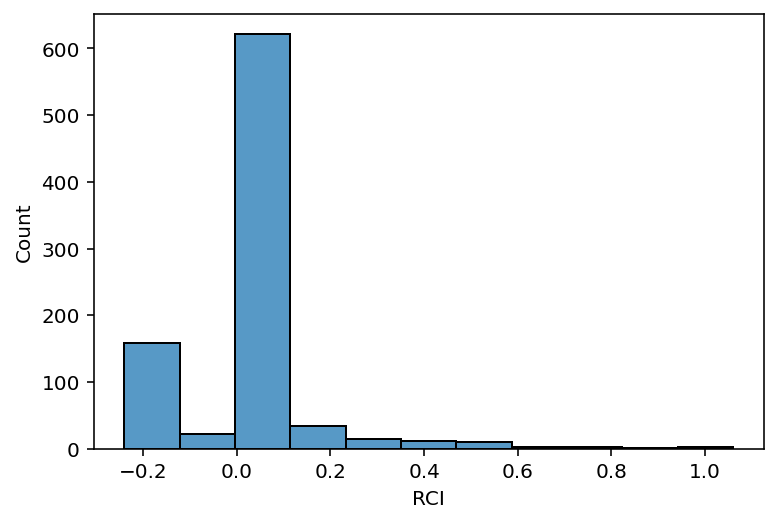

In [91]:
sns.histplot(data=RCI_df, x="RCI")

**Conclusion**

In the above period, developers participating in the LKML have asssumed a fixed role. Developers with a zero RCI are rare contributors. And the ones with a positive RCI tend to be maintainers.
